# Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time


# Part A

## Normalization of data

- We first read both files since the dataset was provided as train and test not as one csv file
- We then dropped the header row from both tables and concatenated them together to create the dataset
- We converted the data into a numpy array for faster operations
- We then seperated the labels into `y` and the features in `X` and set their data types
- Feature values were normalized to take value between `0 and 1`
- Afterwards we split the data into train, validation, and test

In [ ]:
data=pd.read_csv("dataset/mnist_test.csv")
data2=pd.read_csv("dataset/mnist_train.csv")
data2=data2.drop(data2.index[0])
data=data.drop(data.index[0])
data=pd.concat([data,data2])

data_np = data.to_numpy()

# Separate labels (first column) and features (remaining columns)
y = data_np[:, 0].astype(int)
X = data_np[:, 1:].astype(float)

# Normalize pixel values to [0, 1]
X = X / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


  - `reshape()` is a numpy function that changes the dimension of a numpy array without changing the data
  - since the images were in the form of a flattened vector, we can change them back into 28x28 images using the `reshape() `
  - -1 -> it tells the function to automatically calculate this dimesion according to the other dimensions we will specifiy later (this one returns the number of images)
  - 1 -> number of color channels (only 1 since the images are grayscale)
  - 28 -> height
  - 28 -> width

In [ ]:

# Reshape for neural networks
X_train_nn = X_train.reshape(-1, 1, 28, 28)
X_val_nn = X_val.reshape(-1, 1, 28, 28)
X_test_nn = X_test.reshape(-1, 1, 28, 28)


- **`torch.tensor()`** converts a list (in our case numpy arrays) into **`PyTorch tensor`**, which is the core data structure PyTorch models use for computation
- Features have to be float since they are between 0 and 1
- **`CrossEntropyLoss`** only accept 64-bit integer tensors, or **`long`**
- We used the flattened vector form since we are going to use a linear model

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

- Here we also created PyTorch tensors but for the NN models which use the reshaped data

In [ ]:
X_train_nn_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
X_val_nn_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
X_test_nn_tensor = torch.tensor(X_test_nn, dtype=torch.float32)

- **`TensorDataset()`** pairs the labels with the features instead of having them seperated

In [ ]:
train_dataset_flat = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_flat = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_flat = TensorDataset(X_test_tensor, y_test_tensor)

train_dataset_nn = TensorDataset(X_train_nn_tensor, y_train_tensor)
val_dataset_nn = TensorDataset(X_val_nn_tensor, y_val_tensor)
test_dataset_nn = TensorDataset(X_test_nn_tensor, y_test_tensor)

- The **`batch_size`** determines how much data do we feed our model at a time
- We don't give the model the whole dataset at once because of:
  - Memory limitations, we usually cant store the huge amount of data in the memory
  - Giving the model batches is better as it makes the model make small updates to the weights from the start instead of waiting for all the data
- **`DataLoader()`** is responsible for feeding these batches to the model
- It is unnecessary to shuffle the validation and testing data since they arent used to train the model and only used for evaluation

In [ ]:
batch_size = 64

train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat = DataLoader(val_dataset_flat, batch_size=batch_size, shuffle=False)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=batch_size, shuffle=False)

train_loader_nn = DataLoader(train_dataset_nn, batch_size=batch_size, shuffle=True)
val_loader_nn = DataLoader(val_dataset_nn, batch_size=batch_size, shuffle=False)
test_loader_nn = DataLoader(test_dataset_nn, batch_size=batch_size, shuffle=False)

## Binary logistic regression

In [ ]:
# Filter only 0 and 1 from training set
train_mask = (y_train == 0) | (y_train == 1)
val_mask = (y_val == 0) | (y_val == 1)
test_mask = (y_test == 0) | (y_test == 1)

X_train_bin = X_train_tensor[train_mask]
y_train_bin = y_train_tensor[train_mask]

X_val_bin = X_val_tensor[val_mask]
y_val_bin = y_val_tensor[val_mask]

X_test_bin = X_test_tensor[test_mask]
y_test_bin = y_test_tensor[test_mask]

# Create dataloaders
batch_size = 64
train_loader_bin = DataLoader(TensorDataset(X_train_bin, y_train_bin), batch_size=batch_size, shuffle=True)
val_loader_bin = DataLoader(TensorDataset(X_val_bin, y_val_bin), batch_size=batch_size, shuffle=False)
test_loader_bin = DataLoader(TensorDataset(X_test_bin, y_test_bin), batch_size=batch_size, shuffle=False)


In [ ]:
input_dim = 784  # flattened MNIST size

# Weights & bias
W = torch.zeros(input_dim, 1, dtype=torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

learning_rate = 0.01


In [ ]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def binary_cross_entropy(pred, target):
    # Adding small epsilon for numerical stability
    eps = 1e-8
    return -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps)).mean()


In [ ]:
def evaluate(loader):
    correct = 0
    total = 0
    loss_sum = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_batch = y_batch.unsqueeze(1).float()
            logits = X_batch @ W + b
            y_pred = sigmoid(logits)
            loss = binary_cross_entropy(y_pred, y_batch)
            predicted = (y_pred >= 0.5).int()
            correct += (predicted.squeeze() == y_batch.squeeze()).sum().item()
            total += y_batch.size(0)
            loss_sum += loss.item()
    return loss_sum / len(loader), correct / total

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 20

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader_bin:
        y_batch = y_batch.unsqueeze(1).float()
        logits = X_batch @ W + b
        y_pred = sigmoid(logits)

        loss = binary_cross_entropy(y_pred, y_batch)
        loss.backward()

        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        W.grad.zero_()
        b.grad.zero_()

        total_loss += loss.item()
        predicted = (y_pred >= 0.5).int()
        correct += (predicted.squeeze() == y_batch.squeeze()).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader_bin)
    train_acc = correct / total
    val_loss, val_acc = evaluate(val_loader_bin)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


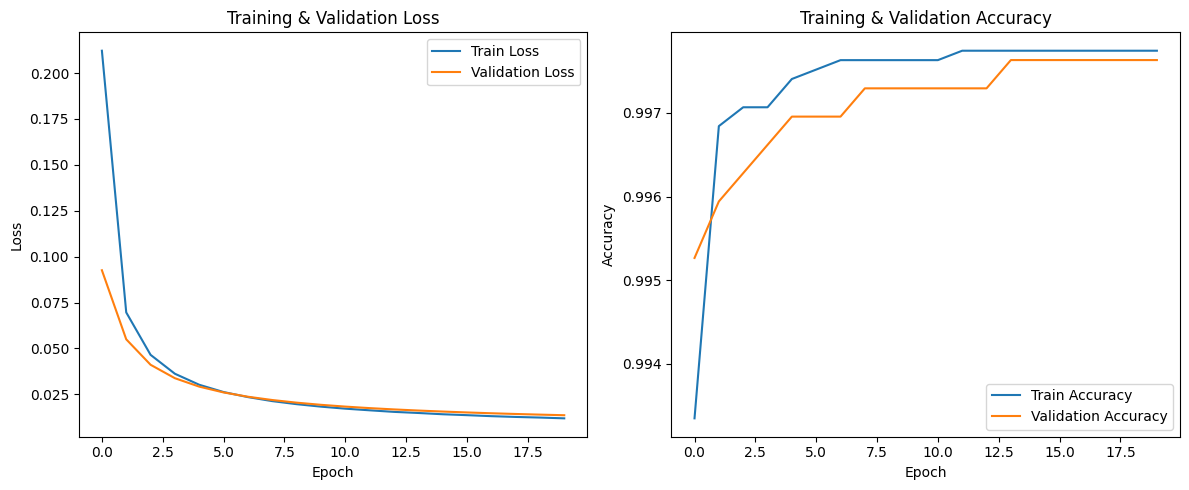

In [ ]:
plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


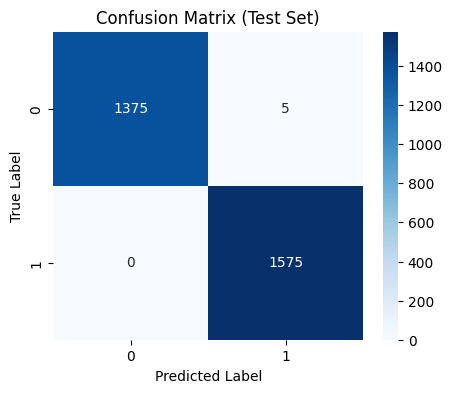

Final Test Accuracy: 0.9983


In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader_bin:
        logits = X_batch @ W + b
        y_pred = sigmoid(logits)
        preds = (y_pred >= 0.5).int().squeeze().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Final Test Accuracy: {test_acc:.4f}")



## Softmax Regression Implementation

### Mini-Batch Gradient Descent Training for Softmax Regression

This function trains a Softmax Regression (multiclass logistic regression) model using mini-batch gradient descent with L2 regularization and early stopping.

#### Features
- **Weight Initialization** using Xavier uniform distribution  
- **Mini-batch Gradient Descent** for faster and more stable training  
- **Cross-Entropy Loss** for multiclass classification  
- **L2 Regularization** to prevent overfitting  
- **Early Stopping** based on validation accuracy to avoid unnecessary training  
- Tracks **training/validation loss and accuracy** for plotting later


In [ ]:
def train_softmax_minibatch(X_train, y_train, X_val, y_val, epochs=100, lr=0.1, batch_size=256, lambda_reg=0.001):
    n_samples = X_train.shape[0]
    num_features = X_train.shape[1]
    num_classes = len(torch.unique(y_train))

    # Initialization for weights
    limit = np.sqrt(6.0 / (num_features + num_classes))
    W = torch.FloatTensor(num_features, num_classes).uniform_(-limit, limit)
    b = torch.zeros(num_classes)

    W.requires_grad = True
    b.requires_grad = True

    # Logs for plots
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # For early stopping
    best_val_acc = 0.0
    best_W, best_b = None, None
    patience_counter = 0    # counts epochs without improvement

    # Main loop
    for epoch in range(epochs):
        # Shuffle training data every epoch
        indices = torch.randperm(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        epoch_loss = 0.0
        epoch_correct = 0
        n_batches = 0

        # Batch training
        for i in range(0, n_samples, batch_size):
            batch_X = X_shuffled[i:i+batch_size]
            batch_y = y_shuffled[i:i+batch_size]

            if len(batch_y) == 0:   # skip empty batch
                continue

            # compute logits
            logits = batch_X @ W + b

            # Cross-entropy loss
            loss = torch.nn.functional.cross_entropy(logits, batch_y)

            # L2 regularization
            if lambda_reg > 0:
                loss = loss + lambda_reg * (W ** 2).sum()

            # compute gradients
            loss.backward()

            # Updating weights
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad

                # Reset gradients for next batch
                W.grad.zero_()
                b.grad.zero_()

            # Training eval
            with torch.no_grad():
                preds = logits.argmax(dim=1)   # convert logits to predicted class
                epoch_correct += (preds == batch_y).sum().item()
                epoch_loss += loss.item()
                n_batches += 1

        train_loss = epoch_loss / n_batches
        train_acc = epoch_correct / n_samples

        # Validation
        with torch.no_grad():
            val_logits = X_val @ W + b
            val_loss = torch.nn.functional.cross_entropy(val_logits, y_val)
            if lambda_reg > 0:
                val_loss = val_loss + lambda_reg * (W ** 2).sum()
            val_preds = val_logits.argmax(dim=1)
            val_acc = (val_preds == y_val).float().mean().item()

        # Store metrics for plots
        train_losses.append(train_loss)
        val_losses.append(val_loss.item())
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_W = W.clone().detach()
            best_b = b.clone().detach()
            patience_counter = 0          # reset patience
        else:
            patience_counter += 1         # no improvement so increase counter

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Stop training if no improvement for 10 epochs
        if patience_counter >= 10:
            break

    # Restore best model parameters before returning
    W.data = best_W
    b.data = best_b

    return W, b, train_losses, val_losses, train_accs, val_accs


### Softmax Regression Training, Evaluation, and Metrics

After training the Softmax Regression model using mini-batch gradient descent, this block:
#### Outputs
- **Learning curves** (loss + accuracy over epochs)
- **Confusion matrix** for visualizing classification errors
- **Classification report** (precision, recall, F1 per class)
- **Final test accuracy (%)**


Epoch 1/100, Loss: 0.8477, Val Acc: 0.8580
Epoch 2/100, Loss: 0.5153, Val Acc: 0.8828
Epoch 3/100, Loss: 0.4650, Val Acc: 0.8921
Epoch 4/100, Loss: 0.4444, Val Acc: 0.8944
Epoch 5/100, Loss: 0.4294, Val Acc: 0.8984
Epoch 6/100, Loss: 0.4244, Val Acc: 0.8979
Epoch 7/100, Loss: 0.4145, Val Acc: 0.9021
Epoch 8/100, Loss: 0.4092, Val Acc: 0.9042
Epoch 9/100, Loss: 0.4037, Val Acc: 0.9053
Epoch 10/100, Loss: 0.3992, Val Acc: 0.9069
Epoch 11/100, Loss: 0.3970, Val Acc: 0.9074
Epoch 12/100, Loss: 0.3953, Val Acc: 0.9083
Epoch 13/100, Loss: 0.3946, Val Acc: 0.9084
Epoch 14/100, Loss: 0.3927, Val Acc: 0.9100
Epoch 15/100, Loss: 0.3903, Val Acc: 0.9065
Epoch 16/100, Loss: 0.3888, Val Acc: 0.9096
Epoch 17/100, Loss: 0.3883, Val Acc: 0.9109
Epoch 18/100, Loss: 0.3865, Val Acc: 0.9097
Epoch 19/100, Loss: 0.3852, Val Acc: 0.9113
Epoch 20/100, Loss: 0.3855, Val Acc: 0.9112
Epoch 21/100, Loss: 0.3857, Val Acc: 0.9129
Epoch 22/100, Loss: 0.3855, Val Acc: 0.9105
Epoch 23/100, Loss: 0.3827, Val Acc: 0.91

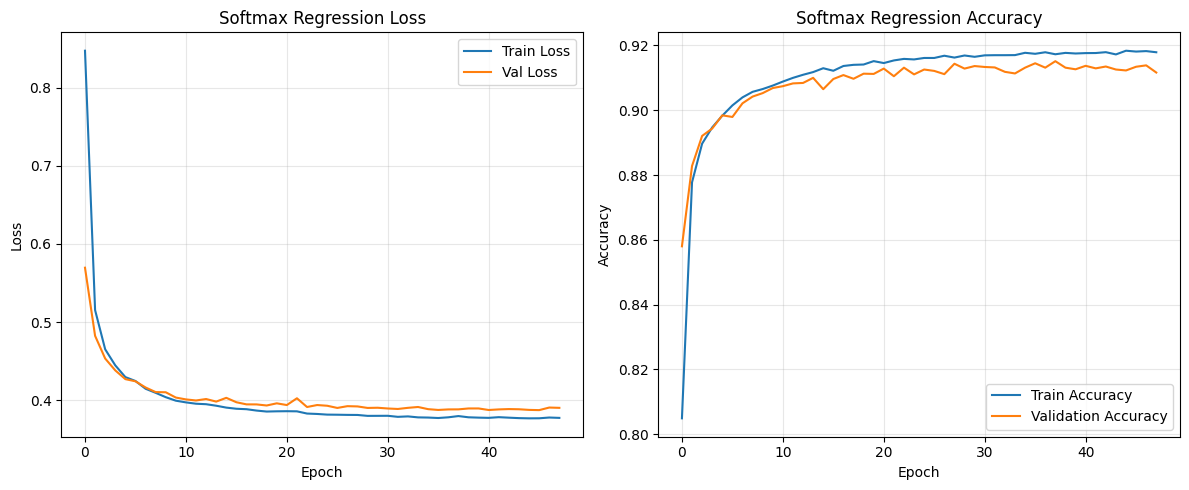

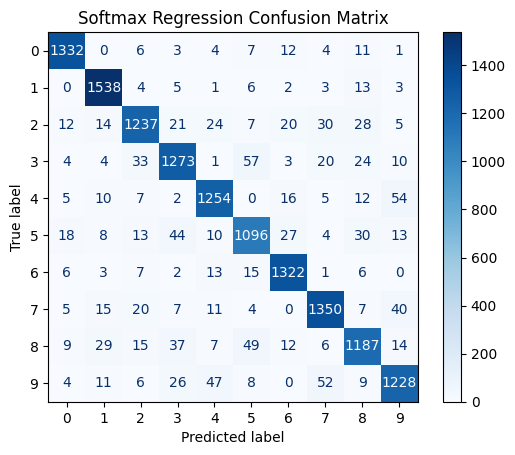


Per-Class Accuracy:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1380
           1       0.94      0.98      0.96      1575
           2       0.92      0.88      0.90      1398
           3       0.90      0.89      0.89      1429
           4       0.91      0.92      0.92      1365
           5       0.88      0.87      0.87      1263
           6       0.93      0.96      0.95      1375
           7       0.92      0.93      0.92      1459
           8       0.89      0.87      0.88      1365
           9       0.90      0.88      0.89      1391

    accuracy                           0.92     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.92      0.92      0.92     14000

Final Test Accuracy: 91.55%


In [ ]:
X_train_mc = torch.tensor(X_train, dtype=torch.float32)
y_train_mc = torch.tensor(y_train, dtype=torch.long)
X_val_mc = torch.tensor(X_val, dtype=torch.float32)
y_val_mc = torch.tensor(y_val, dtype=torch.long)
X_test_mc = torch.tensor(X_test, dtype=torch.float32)
y_test_mc = torch.tensor(y_test, dtype=torch.long)

W, b, train_losses_mc, val_losses_mc, train_accs_mc, val_accs_mc = train_softmax_minibatch(
    X_train_mc, y_train_mc, X_val_mc, y_val_mc,
    epochs=100, lr=0.1, batch_size=256, lambda_reg=0.001
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_mc, label="Train Loss")
plt.plot(val_losses_mc, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Softmax Regression Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs_mc, label="Train Accuracy")
plt.plot(val_accs_mc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Softmax Regression Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

with torch.no_grad():
    test_logits = X_test_mc @ W + b
    test_pred = test_logits.argmax(dim=1)
    test_acc = (test_pred == y_test_mc).float().mean().item()


cm = confusion_matrix(y_test_mc, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Softmax Regression Confusion Matrix")
plt.show()

print("\nPer-Class Accuracy:")
print(classification_report(y_test_mc, test_pred))
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# Part B

### Custom Neural Network Architecture

The **FullyConnectedNN** class implements the ANN. My implementation allows for different depths of the linear NN layers. Some important functions used:
- **nn.Linear**: instantiates a linear transformation layer, that applies the formula `y = xW^T + b`
- **nn.init.kaiming_normal_**: initialises the weights for the layers that use **ReLU** activation function and its variants to account for the fact that on average 50% of the weight would be 0, as **`RelU(x) = max(0, x)`**
- **nn.init.xavier_normal_**: initialises the weights for the layers that use activation functions that have zero mean and unit variance, such as the sigmoid function that is used in softmax regression


In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], num_classes=10):
        super(FullyConnectedNN, self).__init__()

        layers = []
        in_features = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            in_features = h

        layers.append(nn.Linear(in_features, num_classes))

        self.layers = nn.ModuleList(layers)

        for layer in self.layers[:-1]:
            nn.init.kaiming_normal_(layer.weight)
        nn.init.xavier_normal_(self.layers[-1].weight)

    def forward(self, x):
        if x.ndim == 4:
            x = x.view(x.size(0), -1)

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        return self.layers[-1](x)


### Training Infrastructure

Auto-detection of a GPU and using it if exists. Otherwise, fall back onto CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cuda


The **accuracy** function calculates the accuracy per batch by:
- Taking the **outputs**, which are the raw logits, and the **labels**
- Getting the prediction by getting the maximum value using **argmax**
- Calculating the mean of how many predictions actually matched the labels

In [ ]:
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)
    return (preds == labels).float().mean().item()

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.01):
    model = model.to(device) # Move model to device

    criterion = nn.CrossEntropyLoss() # combines softmax and negative log likelihood

    # Stochastic Gradient Descent optimizer
    # model.parameters() gives all learnable parameters of the model to be optimized
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train() # set the model to training mode

        running_loss = 0.0
        running_acc = 0.0

        for X, y in train_loader: # train the model in batches
            X, y = X.to(device), y.to(device)

            outputs = model(X) # calls the forward function and returns raw logits
            loss = criterion(outputs, y) # computes how far the outputs are from the true labels

            optimizer.zero_grad() # reset gradients before backpropagation to prevent unwanted accumulation
            loss.backward() # compute gradients via backpropagation
            optimizer.step() # update model parameters using w = w - lr * gradient

            running_loss += loss.item()
            running_acc += accuracy(outputs, y)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(running_acc / len(train_loader))

        model.eval() # set the model to validation mode
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad(): # disable gradient calculation during validation
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)

                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                val_acc += accuracy(outputs, y)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc / len(val_loader))

        # Log progress
        print(f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}% "
            f"| Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


- Run the fully connected NN model training

In [ ]:
fc_nn_model = FullyConnectedNN()
train_losses, val_losses, train_accs, val_accs = train_model(
    fc_nn_model,
    train_loader_nn,
    val_loader_nn,
    epochs=50,
    lr=0.01
)

Epoch [1/50] Train Loss: 1.0042, Train Acc: 73.19% | Val Loss: 0.4742, Val Acc: 87.58%
Epoch [2/50] Train Loss: 0.3984, Train Acc: 89.08% | Val Loss: 0.3488, Val Acc: 90.20%
Epoch [3/50] Train Loss: 0.3256, Train Acc: 90.84% | Val Loss: 0.3064, Val Acc: 91.33%
Epoch [4/50] Train Loss: 0.2895, Train Acc: 91.80% | Val Loss: 0.2809, Val Acc: 91.93%
Epoch [5/50] Train Loss: 0.2656, Train Acc: 92.52% | Val Loss: 0.2627, Val Acc: 92.33%
Epoch [6/50] Train Loss: 0.2459, Train Acc: 93.05% | Val Loss: 0.2478, Val Acc: 92.72%
Epoch [7/50] Train Loss: 0.2304, Train Acc: 93.47% | Val Loss: 0.2379, Val Acc: 93.25%
Epoch [8/50] Train Loss: 0.2163, Train Acc: 93.96% | Val Loss: 0.2288, Val Acc: 93.30%
Epoch [9/50] Train Loss: 0.2049, Train Acc: 94.29% | Val Loss: 0.2163, Val Acc: 93.70%
Epoch [10/50] Train Loss: 0.1932, Train Acc: 94.61% | Val Loss: 0.2056, Val Acc: 93.95%
Epoch [11/50] Train Loss: 0.1835, Train Acc: 94.83% | Val Loss: 0.1974, Val Acc: 94.16%
Epoch [12/50] Train Loss: 0.1747, Train A

### Performance Visualization
#### `plot_training_history`

Generates two graphs to visualize how a model performs during training.

#### What It Plots

* **Training vs. Validation Loss**: Shows how the model's error changes over epochs. Useful for detecting overfitting if validation loss increases while training loss decreases.
* **Training vs. Validation Accuracy**: Shows how well the model predicts during training compared to unseen validation data.


In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, [acc * 100 for acc in train_accs], 'b-o',
             label='Training Accuracy', linewidth=2, markersize=6)
    ax2.plot(epochs, [acc * 100 for acc in val_accs], 'r-s',
             label='Validation Accuracy', linewidth=2, markersize=6)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



#### `train_model_multiple_runs`

This function trains the same model multiple times and records the performance from each run.  
It is used to generate learning curves with error bars, showing how stable or variable the model is across repeated trainings.

As Neural networks can produce different results on each training due to:
- Random weight initialization
- Random batch shuffling
- Non-deterministic GPU operations  

Running the model several times lets us compute mean ± standard deviation for loss and accuracy.

#### **Returns:**
- A dictionary containing:
   - Mean curves across runs
   - Standard deviation curves (for error bars)

#### **Output is used for:**
- Plotting loss/accuracy curves with shaded error regions  
- Comparing model stability
- Reporting average performance



In [ ]:
def train_model_multiple_runs(model_class, train_loader, val_loader, epochs=20, lr=0.01, num_runs=5):
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []

    for run in range(num_runs):
        print(f"Training Run {run + 1}/{num_runs}")

        model = model_class()

        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accs.append(train_accs)
        all_val_accs.append(val_accs)

    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accs = np.array(all_train_accs)
    all_val_accs = np.array(all_val_accs)

    return {
        'train_loss_mean': all_train_losses.mean(axis=0),
        'train_loss_std': all_train_losses.std(axis=0),
        'val_loss_mean': all_val_losses.mean(axis=0),
        'val_loss_std': all_val_losses.std(axis=0),
        'train_acc_mean': all_train_accs.mean(axis=0),
        'train_acc_std': all_train_accs.std(axis=0),
        'val_acc_mean': all_val_accs.mean(axis=0),
        'val_acc_std': all_val_accs.std(axis=0),
    }


#### **`plot_learning_curves_with_error_bars`**

This function plots the mean training/validation loss and accuracy across multiple runs of a model, including error bars (standard deviation) to show variance between runs.
#### Plots
- **Left plot:** Training & validation loss (mean ± std)
- **Right plot:** Training & validation accuracy (mean ± std)
- Error bars represent uncertainty across runs

**Shows how stable/reliable the training is across different runs**.



In [ ]:
def plot_learning_curves_with_error_bars(stats):
    epochs = range(1, len(stats['train_loss_mean']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.errorbar(epochs, stats['train_loss_mean'], yerr=stats['train_loss_std'],
                 fmt='b-o', label='Training Loss', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax1.errorbar(epochs, stats['val_loss_mean'], yerr=stats['val_loss_std'],
                 fmt='r-s', label='Validation Loss', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax1.fill_between(epochs,
                      stats['train_loss_mean'] - stats['train_loss_std'],
                      stats['train_loss_mean'] + stats['train_loss_std'],
                      alpha=0.2, color='blue')
    ax1.fill_between(epochs,
                      stats['val_loss_mean'] - stats['val_loss_std'],
                      stats['val_loss_mean'] + stats['val_loss_std'],
                      alpha=0.2, color='red')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Learning Curves: Loss (Mean ± Std)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    train_acc_mean_pct = stats['train_acc_mean'] * 100
    train_acc_std_pct = stats['train_acc_std'] * 100
    val_acc_mean_pct = stats['val_acc_mean'] * 100
    val_acc_std_pct = stats['val_acc_std'] * 100

    ax2.errorbar(epochs, train_acc_mean_pct, yerr=train_acc_std_pct,
                 fmt='b-o', label='Training Accuracy', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax2.errorbar(epochs, val_acc_mean_pct, yerr=val_acc_std_pct,
                 fmt='r-s', label='Validation Accuracy', capsize=5, linewidth=2,
                 markersize=6, alpha=0.8)
    ax2.fill_between(epochs,
                      train_acc_mean_pct - train_acc_std_pct,
                      train_acc_mean_pct + train_acc_std_pct,
                      alpha=0.2, color='blue')
    ax2.fill_between(epochs,
                      val_acc_mean_pct - val_acc_std_pct,
                      val_acc_mean_pct + val_acc_std_pct,
                      alpha=0.2, color='red')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Learning Curves: Accuracy (Mean ± Std)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


#### **Convergence Analysis Function**
Checks whether the training has converged by analyzing how much the loss changes between epochs.

1. Computes the **absolute loss change** between consecutive epochs for both training and validation losses.
2. Slides a window of size `window_size` across the training loss changes.
3. If the **mean loss change** inside that window is below `threshold`, the model is considered *converged* at that epoch.
#### **Plots:**
   - Training loss change per epoch
   - Validation loss change per epoch
   - Horizontal line showing the convergence threshold
   - Vertical line showing detected convergence epoch (if converged)


In [ ]:
def analyze_convergence(train_losses, val_losses, window_size=3, threshold=0.01):
    epochs = len(train_losses)

    train_loss_changes = np.abs(np.diff(train_losses))
    val_loss_changes = np.abs(np.diff(val_losses))

    converged_epoch = None
    for i in range(window_size - 1, len(train_loss_changes)):
        window = train_loss_changes[i - window_size + 1:i + 1]
        if np.mean(window) < threshold:
            converged_epoch = i + 2  # +2 because diff reduces length by 1
            break

    # Plot loss change over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, epochs + 1), train_loss_changes, 'b-o',
             label='Training Loss Change', linewidth=2, markersize=4)
    plt.plot(range(2, epochs + 1), val_loss_changes, 'r-s',
             label='Validation Loss Change', linewidth=2, markersize=4)
    plt.axhline(y=threshold, color='g', linestyle='--',
                label=f'Convergence Threshold ({threshold})')

    if converged_epoch:
        plt.axvline(x=converged_epoch, color='purple', linestyle='--',
                   label=f'Converged at Epoch {converged_epoch}')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Absolute Loss Change', fontsize=12)
    plt.title('Convergence Analysis: Loss Change Over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print convergence status
    print("Convergence Analysis")
    if converged_epoch:
        print(f"Model converged at epoch {converged_epoch}")
    else:
        print(f"Model did not converge within {epochs} epochs")
        print(f"Consider training for more epochs")


#### Training Workflow Overview
This script performs the analysis steps after training a neural network model.

Plotting training history for single run...


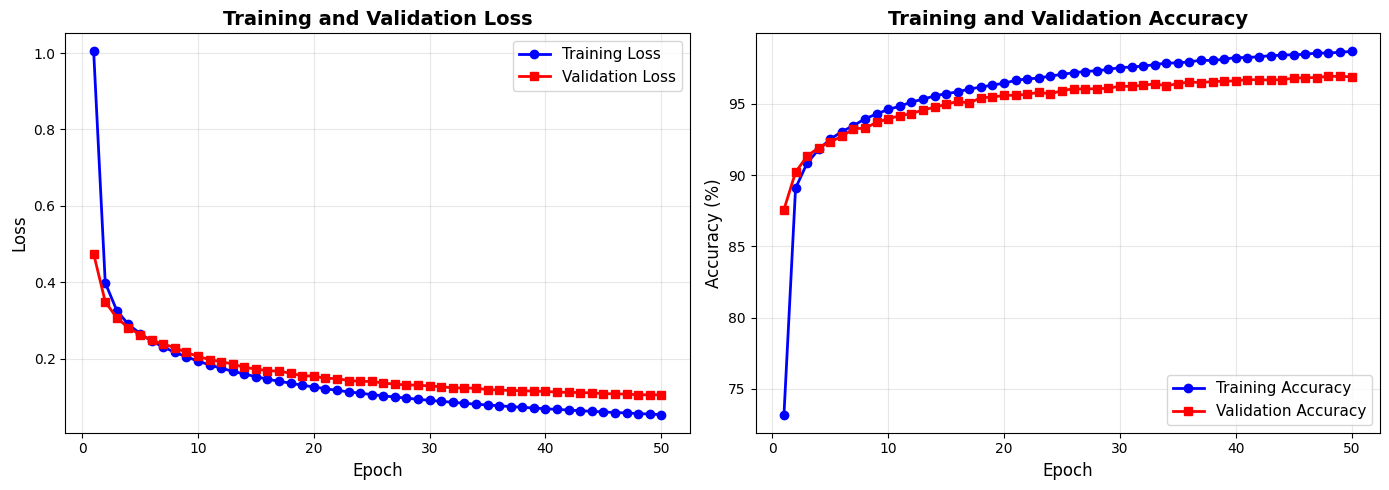


Training model multiple times for statistical analysis...

Training Run 1/3
Epoch [1/10] Train Loss: 1.0095, Train Acc: 73.71% | Val Loss: 0.4982, Val Acc: 86.51%
Epoch [2/10] Train Loss: 0.4120, Train Acc: 88.72% | Val Loss: 0.3590, Val Acc: 89.73%
Epoch [3/10] Train Loss: 0.3323, Train Acc: 90.65% | Val Loss: 0.3132, Val Acc: 91.06%
Epoch [4/10] Train Loss: 0.2956, Train Acc: 91.64% | Val Loss: 0.2989, Val Acc: 91.45%
Epoch [5/10] Train Loss: 0.2689, Train Acc: 92.37% | Val Loss: 0.2660, Val Acc: 92.44%
Epoch [6/10] Train Loss: 0.2500, Train Acc: 92.90% | Val Loss: 0.2528, Val Acc: 92.74%
Epoch [7/10] Train Loss: 0.2333, Train Acc: 93.37% | Val Loss: 0.2368, Val Acc: 93.29%
Epoch [8/10] Train Loss: 0.2184, Train Acc: 93.83% | Val Loss: 0.2238, Val Acc: 93.71%
Epoch [9/10] Train Loss: 0.2060, Train Acc: 94.24% | Val Loss: 0.2173, Val Acc: 93.71%
Epoch [10/10] Train Loss: 0.1952, Train Acc: 94.52% | Val Loss: 0.2286, Val Acc: 93.49%

Training Run 2/3
Epoch [1/10] Train Loss: 1.0450, T

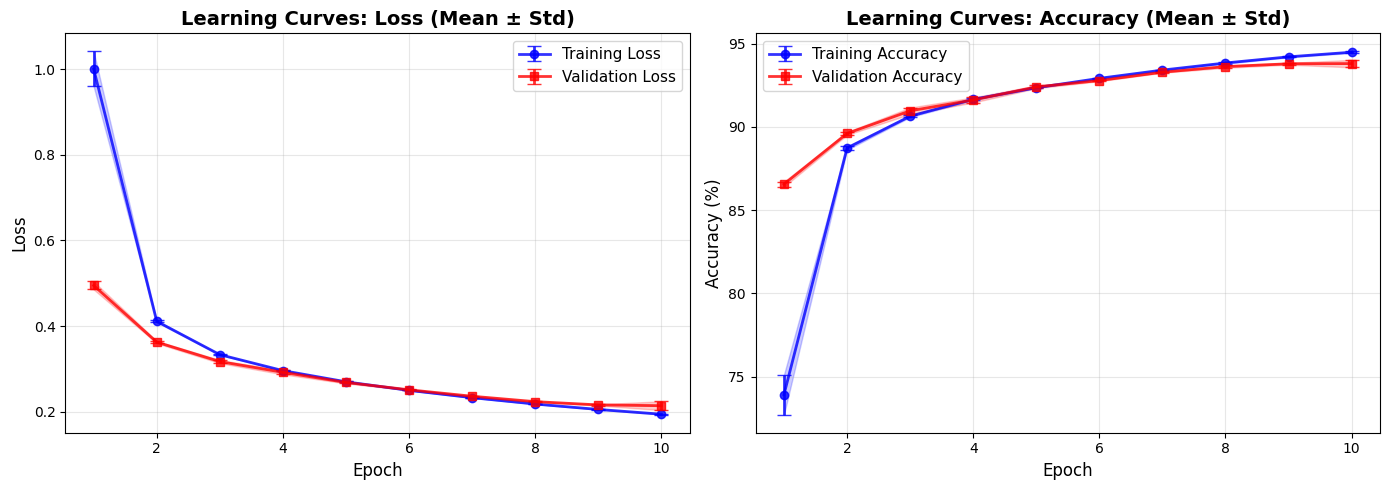


Performing convergence analysis...


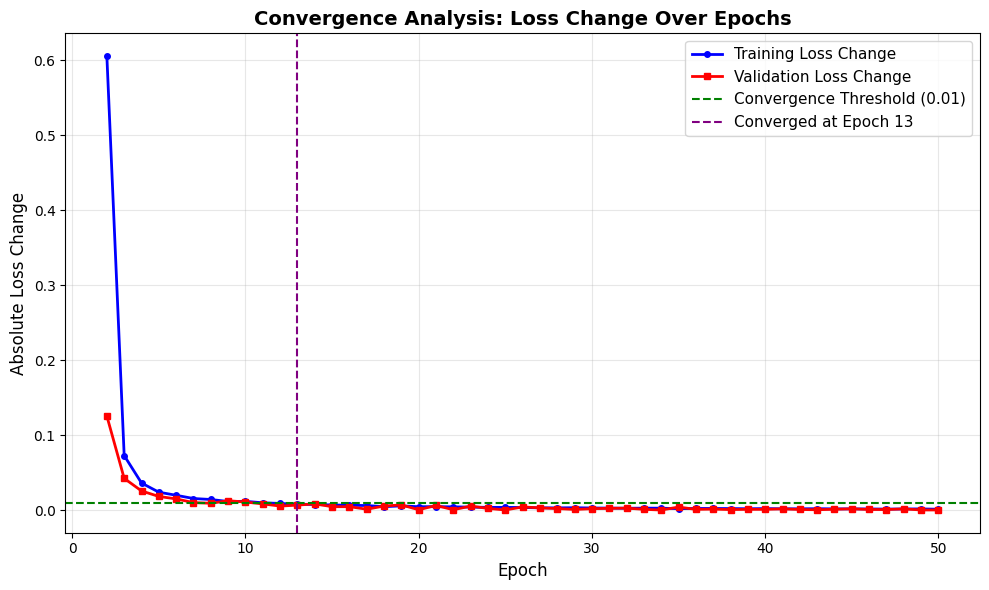

CONVERGENCE ANALYSIS
Model converged at epoch 13


In [ ]:
# 1. Simple visualization of single training run
print("Plotting training history for single run...")
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# 2. Multiple runs with error bars (uncomment to use)
print("\nTraining model multiple times for statistical analysis...")
stats = train_model_multiple_runs(
    FullyConnectedNN,
    train_loader_nn,
    val_loader_nn,
    epochs=10,
    lr=0.01,
    num_runs=3
)
plot_learning_curves_with_error_bars(stats)

# 3. Convergence analysis
print("\nPerforming convergence analysis...")
analyze_convergence(train_losses, val_losses)

# Part C

### Hyperparameter Analysis

#### **Learning Rate Analysis Function**
This function tests multiple learning rates to evaluate how they affect model performance during training.

- Trains the same model several times, each with a different **learning rate**.
- Records loss and accuracy for both training and validation sets.
- Plots curves to visually compare performance across learning rates.
- Prints a summary table showing:
  - Best validation accuracy per learning rate
  - Final validation accuracy
  - Epoch where best accuracy occurred
  - Whether training was stable or not

In [ ]:
def learning_rate_analysis(model_fn, train_loader, val_loader,
                           learning_rates=[0.001, 0.01, 0.1, 1.0],
                           epochs=20, model_name="Model"):
    results = {}
    print(f"Learning Rate - {model_name}")

    for lr in learning_rates:
        print(f"\nTesting learning rate: {lr}")

        model = model_fn()
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )

        results[lr] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'convergence_epoch': np.argmax(val_accs) + 1
        }

        print(f"Best Val Acc: {results[lr]['best_val_acc']*100:.2f}% "
              f"at epoch {results[lr]['convergence_epoch']}")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training Loss
    for lr in learning_rates:
        axes[0, 0].plot(results[lr]['train_losses'],
                       label=f'LR={lr}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Training Loss', fontsize=11)
    axes[0, 0].set_title('Training Loss vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Validation Loss
    for lr in learning_rates:
        axes[0, 1].plot(results[lr]['val_losses'],
                       label=f'LR={lr}', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Validation Loss', fontsize=11)
    axes[0, 1].set_title('Validation Loss vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Training Accuracy
    for lr in learning_rates:
        axes[1, 0].plot([acc*100 for acc in results[lr]['train_accs']],
                       label=f'LR={lr}', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Training Accuracy (%)', fontsize=11)
    axes[1, 0].set_title('Training Accuracy vs Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Validation Accuracy
    for lr in learning_rates:
        axes[1, 1].plot([acc*100 for acc in results[lr]['val_accs']],
                       label=f'LR={lr}', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Validation Accuracy vs Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(f'Learning Rate Analysis - {model_name}',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n" + "="*70)
    print("Summary:")
    summary_data = []
    for lr in learning_rates:
        summary_data.append({
            'Learning Rate': lr,
            'Best Val Acc (%)': f"{results[lr]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[lr]['final_val_acc']*100:.2f}",
            'Convergence Epoch': results[lr]['convergence_epoch'],
            'Stability': 'Stable' if results[lr]['best_val_acc'] > 0.85 else 'Unstable'
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))

    return results


#### **Batch Size Analysis**
This function evaluates how different batch sizes affect model training behavior, accuracy, speed, and gradient noise.

For each batch size in the list:
- Creates a new dataloader using that batch size
- Trains the model and records:
  - Training / Validation loss
  - Training / Validation accuracy
  - Total training time
- Stores all results and plots comparisons

In [ ]:
def batch_size_analysis(model_fn, X_train, y_train, X_val, y_val,
                       batch_sizes=[16, 32, 64, 128],
                       epochs=20, lr=0.01, model_name="Model"):
    from torch.utils.data import TensorDataset, DataLoader

    results = {}
    print(f"Batch Size - {model_name}")
    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")

        # Create data loaders with current batch size
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train model and measure time
        model = model_fn()
        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )
        training_time = time() - start_time

        results[batch_size] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'training_time': training_time,
            'gradient_noise': np.std(np.diff(train_losses))
        }

        print(f"Best Val Acc: {results[batch_size]['best_val_acc']*100:.2f}%")
        print(f"Training Time: {training_time:.2f}s")
        print(f"Gradient Noise (std of loss changes): {results[batch_size]['gradient_noise']:.4f}")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Validation Accuracy
    for bs in batch_sizes:
        axes[0, 0].plot([acc*100 for acc in results[bs]['val_accs']],
                       label=f'BS={bs}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[0, 0].set_title('Validation Accuracy vs Batch Size', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Training Loss (shows gradient noise)
    for bs in batch_sizes:
        axes[0, 1].plot(results[bs]['train_losses'],
                       label=f'BS={bs}', linewidth=2, alpha=0.7)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Training Loss', fontsize=11)
    axes[0, 1].set_title('Training Loss vs Batch Size (Gradient Noise)',
                        fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Training Time
    batch_sizes_list = list(batch_sizes)
    times = [results[bs]['training_time'] for bs in batch_sizes]
    axes[1, 0].bar(range(len(batch_sizes_list)), times, color='steelblue')
    axes[1, 0].set_xticks(range(len(batch_sizes_list)))
    axes[1, 0].set_xticklabels(batch_sizes_list)
    axes[1, 0].set_xlabel('Batch Size', fontsize=11)
    axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
    axes[1, 0].set_title('Training Efficiency vs Batch Size', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Final Performance vs Batch Size
    final_accs = [results[bs]['final_val_acc']*100 for bs in batch_sizes]
    axes[1, 1].plot(batch_sizes_list, final_accs, 'o-', linewidth=2, markersize=8, color='coral')
    axes[1, 1].set_xlabel('Batch Size', fontsize=11)
    axes[1, 1].set_ylabel('Final Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Final Performance vs Batch Size', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(f'Batch Size Analysis - {model_name}',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSummary:")
    summary_data = []
    for bs in batch_sizes:
        summary_data.append({
            'Batch Size': bs,
            'Best Val Acc (%)': f"{results[bs]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[bs]['final_val_acc']*100:.2f}",
            'Training Time (s)': f"{results[bs]['training_time']:.2f}",
            'Gradient Noise': f"{results[bs]['gradient_noise']:.4f}",
            'Efficiency': 'High' if results[bs]['training_time'] < np.median(times) else 'Low'
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))
    return results


#### **Neural Network Architecture Analysis**

This function studies the change of depth (number of layers) and width (neurons per layer) of a fully connected neural network and its effect on performance, training time, and model size.
#### Part 1 Varying Number of Layers  
**Fixed width:** 128 neurons per layer  
**Varied:** `num_layers_list = [2, 3, 4, 5]`
- Train models and record:
  - Training & validation loss curves
  - Training & validation accuracy curves
  - Total Number of parameters
  - Training time

#### Part 2 Varying Neurons per Layer  
**Fixed depth:** 3 hidden layers  
**Varied:** `neurons_list = [64, 128, 256, 512]`


#### **Plots:**

- **Validation Accuracy vs Depth** Compares learning progress for 2–5 layers
- **Validation Accuracy vs Width** Compares 64–512 neurons per layer
- **Performance vs Parameter Count (Depth)** Shows scaling effect of adding layers
- **Performance vs Parameter Count (Width)** Shows scaling effect of adding neurons

In [ ]:
def architecture_analysis(X_train, y_train, X_val, y_val,
                         num_layers_list=[2, 3, 4, 5],
                         neurons_list=[64, 128, 256, 512],
                         epochs=20, lr=0.01, batch_size=64):
    from torch.utils.data import TensorDataset, DataLoader

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    results = {}
    print("Architecture Analysis (NN)")

    # Part 1: Varying number of layers (with fixed neurons per layer)
    print("\n Part 1: Varying Number of Layers (128 neurons per layer)")
    layer_results = {}

    for num_layers in num_layers_list:
        print(f"\nTesting {num_layers} hidden layers")

        hidden_sizes = [128] * num_layers
        model = FullyConnectedNN(input_size=784, hidden_sizes=hidden_sizes, num_classes=10)

        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )
        training_time = time() - start_time

        # Count parameters
        num_params = sum(p.numel() for p in model.parameters())

        layer_results[num_layers] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'num_params': num_params,
            'training_time': training_time
        }

        print(f"Best Val Acc: {layer_results[num_layers]['best_val_acc']*100:.2f}%")
        print(f"Parameters: {num_params:,}")
        print(f"Training Time: {training_time:.2f}s")

    # Part 2: Varying neurons per layer (fixed 3 layers)
    print("\nPart 2: Varying Neurons per Layer (3 hidden layers)")
    neuron_results = {}

    for neurons in neurons_list:
        print(f"\nTesting {neurons} neurons per layer")

        hidden_sizes = [neurons, neurons, neurons]
        model = FullyConnectedNN(input_size=784, hidden_sizes=hidden_sizes, num_classes=10)

        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )
        training_time = time() - start_time

        num_params = sum(p.numel() for p in model.parameters())

        neuron_results[neurons] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'num_params': num_params,
            'training_time': training_time
        }

        print(f"Best Val Acc: {neuron_results[neurons]['best_val_acc']*100:.2f}%")
        print(f"Parameters: {num_params:,}")
        print(f"Training Time: {training_time:.2f}s")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Number of layers Validation Accuracy
    for num_layers in num_layers_list:
        axes[0, 0].plot([acc*100 for acc in layer_results[num_layers]['val_accs']],
                       label=f'{num_layers} layers', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[0, 0].set_title('Effect of Network Depth', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Neurons per layer Validation Accuracy
    for neurons in neurons_list:
        axes[0, 1].plot([acc*100 for acc in neuron_results[neurons]['val_accs']],
                       label=f'{neurons} neurons', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[0, 1].set_title('Effect of Network Width', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Performance vs Parameters (Layers)
    params_layers = [layer_results[n]['num_params'] for n in num_layers_list]
    accs_layers = [layer_results[n]['best_val_acc']*100 for n in num_layers_list]
    axes[1, 0].plot(params_layers, accs_layers, 'o-', linewidth=2, markersize=8)
    for i, n in enumerate(num_layers_list):
        axes[1, 0].annotate(f'{n} layers', (params_layers[i], accs_layers[i]),
                           textcoords="offset points", xytext=(0,10), ha='center')
    axes[1, 0].set_xlabel('Number of Parameters', fontsize=11)
    axes[1, 0].set_ylabel('Best Validation Accuracy (%)', fontsize=11)
    axes[1, 0].set_title('Performance vs Model Size (Depth)', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Performance vs Parameters (Neurons)
    params_neurons = [neuron_results[n]['num_params'] for n in neurons_list]
    accs_neurons = [neuron_results[n]['best_val_acc']*100 for n in neurons_list]
    axes[1, 1].plot(params_neurons, accs_neurons, 'o-', linewidth=2, markersize=8, color='coral')
    for i, n in enumerate(neurons_list):
        axes[1, 1].annotate(f'{n} neurons', (params_neurons[i], accs_neurons[i]),
                           textcoords="offset points", xytext=(0,10), ha='center')
    axes[1, 1].set_xlabel('Number of Parameters', fontsize=11)
    axes[1, 1].set_ylabel('Best Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Performance vs Model Size (Width)', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Architecture Analysis (NN)',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary tables
    print("\nArchitecture Analysis Summary")

    print("\nNumber of Layers (128 neurons each)")
    layer_data = []
    for num_layers in num_layers_list:
        layer_data.append({
            'Hidden Layers': num_layers,
            'Architecture': f"[{', '.join(['128']*num_layers)}]",
            'Parameters': f"{layer_results[num_layers]['num_params']:,}",
            'Best Val Acc (%)': f"{layer_results[num_layers]['best_val_acc']*100:.2f}",
            'Training Time (s)': f"{layer_results[num_layers]['training_time']:.2f}"
        })
    df_layers = pd.DataFrame(layer_data)
    print(df_layers.to_string(index=False))

    print("\nNeurons per Layer (3 layers)")
    neuron_data = []
    for neurons in neurons_list:
        neuron_data.append({
            'Neurons/Layer': neurons,
            'Architecture': f"[{neurons}, {neurons}, {neurons}]",
            'Parameters': f"{neuron_results[neurons]['num_params']:,}",
            'Best Val Acc (%)': f"{neuron_results[neurons]['best_val_acc']*100:.2f}",
            'Training Time (s)': f"{neuron_results[neurons]['training_time']:.2f}"
        })
    df_neurons = pd.DataFrame(neuron_data)
    print(df_neurons.to_string(index=False))

    return layer_results, neuron_results

#### Hyperparameter Experiments Run

- **Learning Rate Analysis** → explores effect of `lr = [0.001, 0.01, 0.1, 1.0]`
- **Batch Size Analysis** → compares `batch_sizes = [16, 32, 64, 128]`
- **Architecture Analysis**  
  - Varying depth: `num_layers = [2, 3, 4, 5]`  
  - Varying width: `neurons per layer = [64, 128, 256, 512]`


BATCH SIZE ANALYSIS - Neural Network

Testing batch size: 16
--------------------------------------------------
Epoch [1/20] Train Loss: 0.5327, Train Acc: 85.25% | Val Loss: 0.2871, Val Acc: 91.76%
Epoch [2/20] Train Loss: 0.2471, Train Acc: 92.77% | Val Loss: 0.2221, Val Acc: 93.51%
Epoch [3/20] Train Loss: 0.1950, Train Acc: 94.32% | Val Loss: 0.1929, Val Acc: 94.46%
Epoch [4/20] Train Loss: 0.1629, Train Acc: 95.26% | Val Loss: 0.1723, Val Acc: 95.14%
Epoch [5/20] Train Loss: 0.1398, Train Acc: 95.98% | Val Loss: 0.1544, Val Acc: 95.63%
Epoch [6/20] Train Loss: 0.1228, Train Acc: 96.52% | Val Loss: 0.1439, Val Acc: 95.89%
Epoch [7/20] Train Loss: 0.1091, Train Acc: 96.84% | Val Loss: 0.1349, Val Acc: 96.08%
Epoch [8/20] Train Loss: 0.0977, Train Acc: 97.23% | Val Loss: 0.1281, Val Acc: 96.31%
Epoch [9/20] Train Loss: 0.0884, Train Acc: 97.45% | Val Loss: 0.1236, Val Acc: 96.36%
Epoch [10/20] Train Loss: 0.0802, Train Acc: 97.76% | Val Loss: 0.1164, Val Acc: 96.78%
Epoch [11/20] Tra

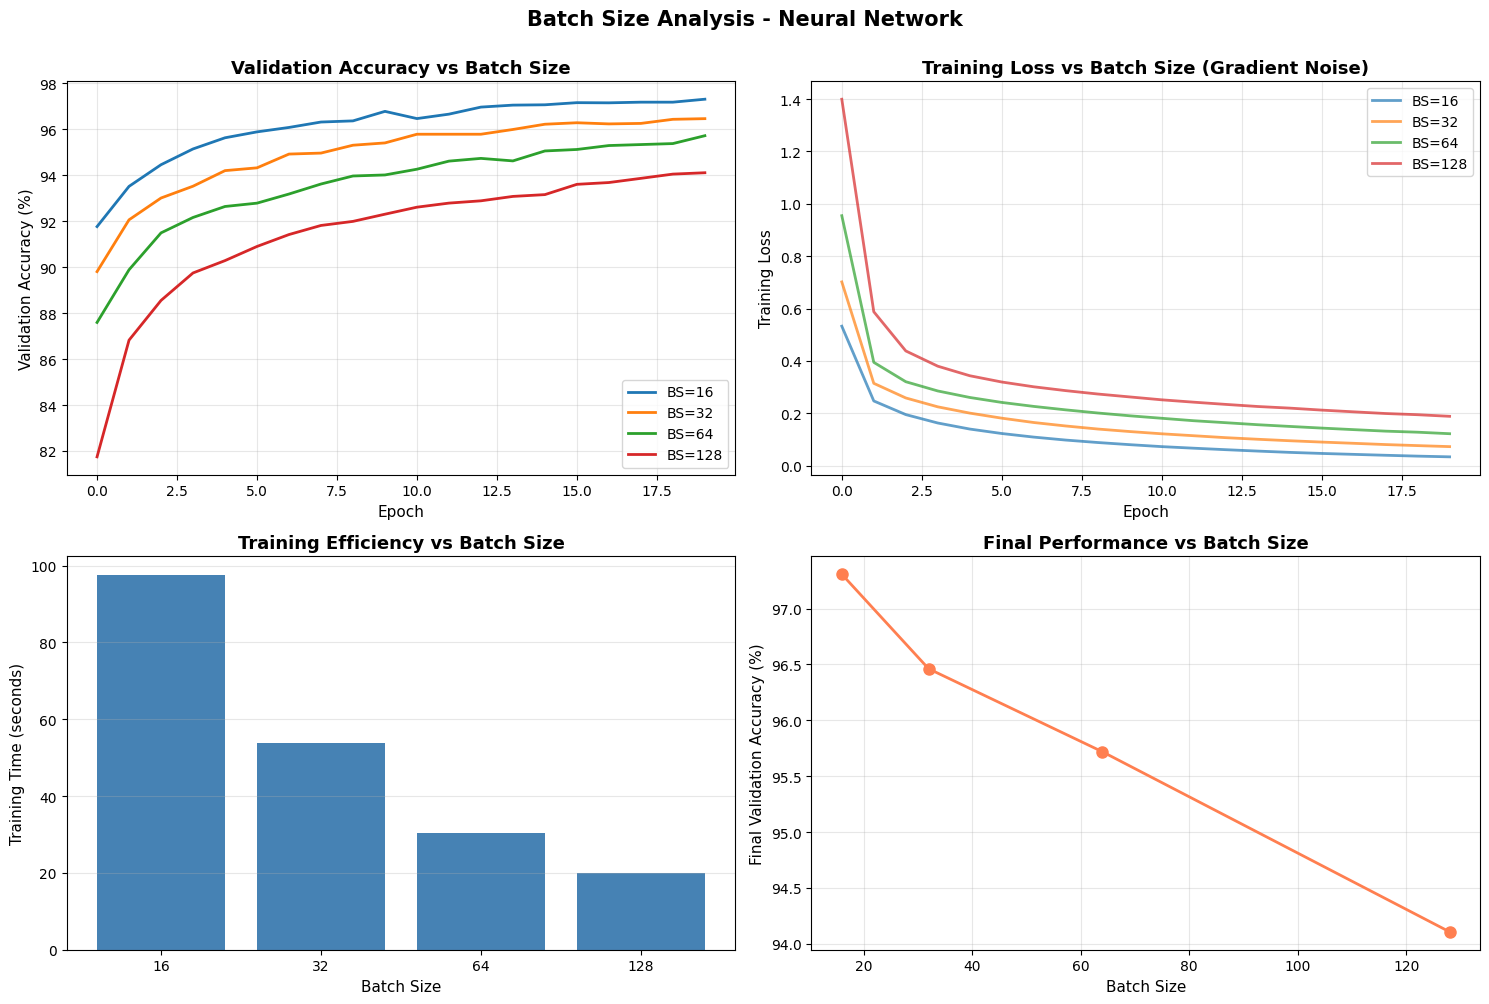


BATCH SIZE SUMMARY
 Batch Size Best Val Acc (%) Final Val Acc (%) Training Time (s) Gradient Noise Efficiency
         16            97.31             97.31             97.55         0.0623        Low
         32            96.46             96.46             53.95         0.0845        Low
         64            95.72             95.72             30.45         0.1227       High
        128            94.11             94.11             19.98         0.1793       High

Analysis:
• Smaller batch sizes → More gradient noise (noisier training)
• Larger batch sizes → Faster training but may converge to worse minima
• Trade-off: Batch size 32-64 often optimal for both speed and performance
ARCHITECTURE ANALYSIS - Neural Network

--- Part 1: Varying Number of Layers (128 neurons per layer) ---

Testing 2 hidden layers
--------------------------------------------------
Epoch [1/20] Train Loss: 0.9621, Train Acc: 74.43% | Val Loss: 0.4627, Val Acc: 87.29%
Epoch [2/20] Train Loss: 0.3899, Tra

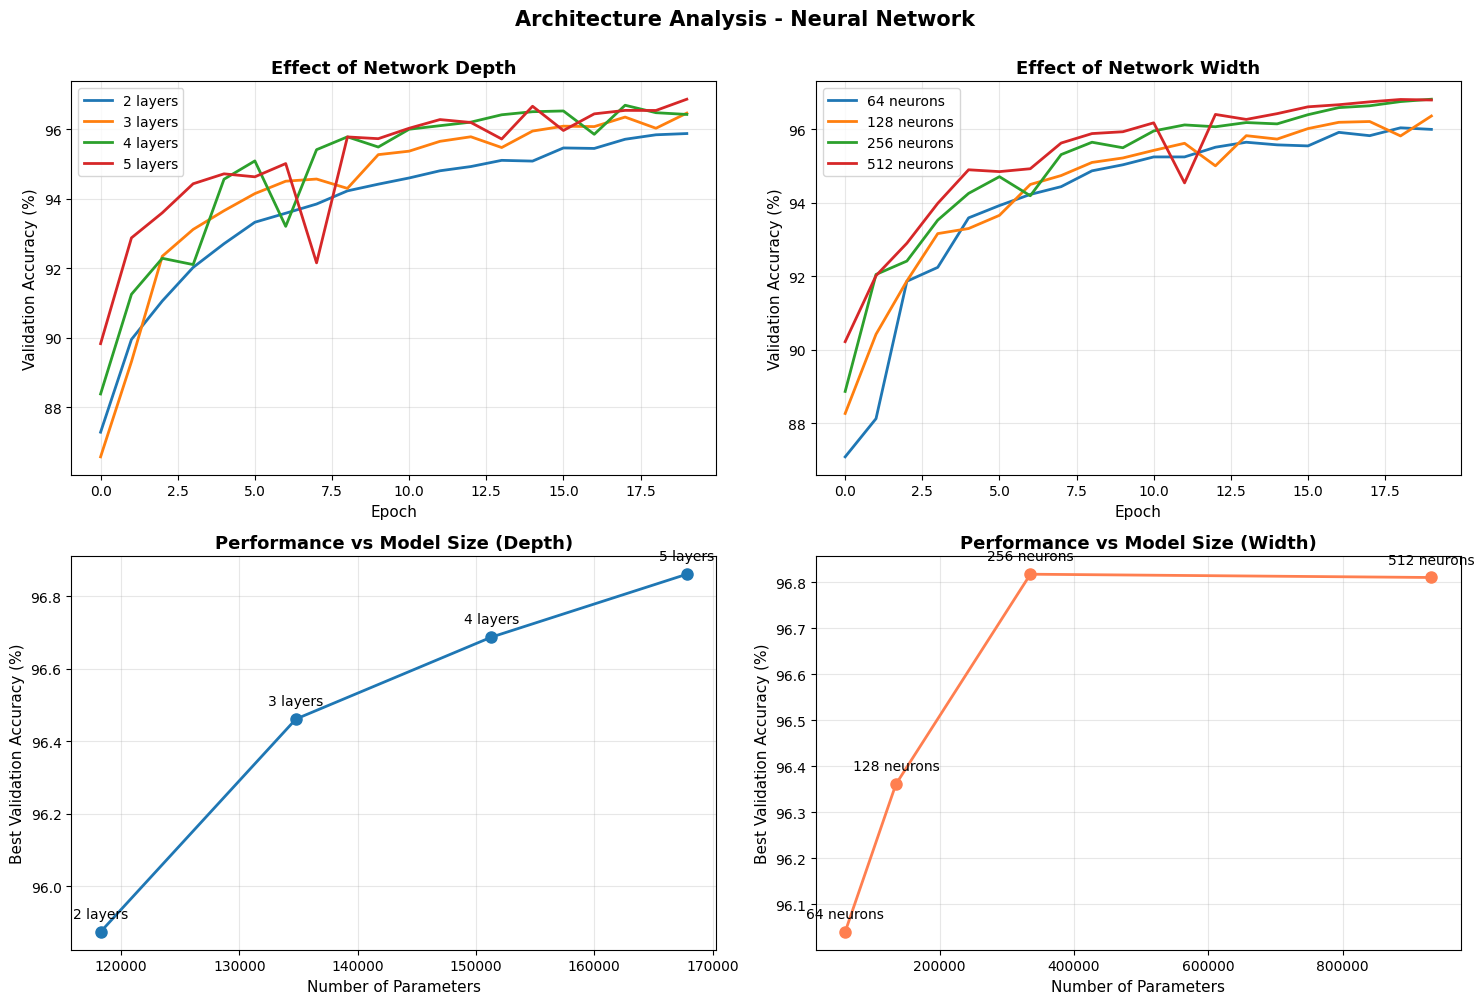


ARCHITECTURE COMPARISON TABLE

--- Number of Layers (128 neurons each) ---
 Hidden Layers              Architecture Parameters Best Val Acc (%) Training Time (s)
             2                [128, 128]    118,282            95.87             30.48
             3           [128, 128, 128]    134,794            96.46             33.40
             4      [128, 128, 128, 128]    151,306            96.69             35.91
             5 [128, 128, 128, 128, 128]    167,818            96.86             38.84

--- Neurons per Layer (3 layers) ---
 Neurons/Layer    Architecture Parameters Best Val Acc (%) Training Time (s)
            64    [64, 64, 64]     59,210            96.04             33.37
           128 [128, 128, 128]    134,794            96.36             33.02
           256 [256, 256, 256]    335,114            96.82             33.29
           512 [512, 512, 512]    932,362            96.81             33.73

KEY INSIGHTS:
• Deeper networks (more layers) can learn more comp

In [ ]:
results_lr = learning_rate_analysis(
    model_fn=lambda: FullyConnectedNN(),
    train_loader=train_loader_nn,
    val_loader=val_loader_nn,
    learning_rates=[0.001, 0.01, 0.1, 1.0],
    epochs=20,
    model_name="Neural Network"
)

results_bs = batch_size_analysis(
    model_fn=lambda: FullyConnectedNN(),
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    batch_sizes=[16, 32, 64, 128],
    epochs=20,
    lr=0.01,
    model_name="Neural Network"
)

layer_results, neuron_results = architecture_analysis(
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    num_layers_list=[2, 3, 4, 5],
    neurons_list=[64, 128, 256, 512],
    epochs=20,
    lr=0.01,
    batch_size=64
)

### **`train_logistic_regression` and `train_softmax_regression`**
Used in the learning rate and batch size experiments in this project.  
- **Learning rate (`lr`)**
- **Batch size (`batch_size`)**
- **Epoch count**
- Manual weight updates (no optimizer abstraction)


In [ ]:
def train_logistic_regression(X_train, y_train, X_val, y_val,
                              epochs=20, lr=0.01, batch_size=64):
    # Get input dimension
    input_dim = X_train.shape[1]
    # Initialize weights and bias with zeros
    W = torch.zeros(input_dim, 1, dtype=torch.float32, requires_grad=True)
    b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Sigmoid activation function
    def sigmoid(z):
        return 1 / (1 + torch.exp(-z))

    # Binary Cross Entropy loss function
    def binary_cross_entropy(pred, target):
        eps = 1e-8  # Adding small epsilon for numerical stability
        return -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps)).mean()

    # Evaluation function to calculate loss and accuracy
    def evaluate(loader):
        correct = 0
        total = 0
        loss_sum = 0
        with torch.no_grad(): # Disable gradient calculation during evaluation
            for X_batch, y_batch in loader:
                y_batch = y_batch.unsqueeze(1).float()
                logits = X_batch @ W + b
                y_pred = sigmoid(logits)
                loss = binary_cross_entropy(y_pred, y_batch)
                predicted = (y_pred >= 0.5).int() # Get predicted class (0 or 1)
                correct += (predicted.squeeze() == y_batch.squeeze()).sum().item() # Count correct predictions
                total += y_batch.size(0)
                loss_sum += loss.item()
        return loss_sum / len(loader), correct / total # Returns average loss and accuracy

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader: # Iterate over batches
            y_batch = y_batch.unsqueeze(1).float() # Reshape target
            logits = X_batch @ W + b # Calculate logits
            y_pred = sigmoid(logits) # Apply sigmoid
            loss = binary_cross_entropy(y_pred, y_batch) # Calculate loss

            loss.backward() # Backpropagation to compute gradients

            # Manual gradient descent update
            with torch.no_grad(): # Disable gradient calculation for parameter updates
                W -= lr * W.grad
                b -= lr * b.grad
            W.grad.zero_() # Reset weight gradients
            b.grad.zero_() # Reset bias gradients

            total_loss += loss.item()
            predicted = (y_pred >= 0.5).int()
            correct += (predicted.squeeze() == y_batch.squeeze()).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_loader) # Calculate average training loss
        train_acc = correct / total # Calculate training accuracy
        val_loss, val_acc = evaluate(val_loader) # Evaluate on validation set

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

def train_softmax_regression(X_train, y_train, X_val, y_val,
                            epochs=50, lr=0.1, batch_size=256, lambda_reg=0.001):

    # Get dataset dimensions
    n_samples = X_train.shape[0]
    num_features = X_train.shape[1]
    num_classes = len(torch.unique(y_train))   # number of output classes

    # Initialize weights using Xavier uniform distribution
    limit = np.sqrt(6.0 / (num_features + num_classes))
    W = torch.FloatTensor(num_features, num_classes).uniform_(-limit, limit)
    b = torch.zeros(num_classes)
    W.requires_grad = True
    b.requires_grad = True

    # Lists to store training history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_W, best_b = None, None
    patience_counter = 0  # used for early stopping

    # Training loop
    for epoch in range(epochs):

        # Shuffle dataset every epoch
        indices = torch.randperm(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        epoch_loss = 0.0
        epoch_correct = 0
        n_batches = 0

        # Mini-batch training loop
        for i in range(0, n_samples, batch_size):
            batch_X = X_shuffled[i:i+batch_size]
            batch_y = y_shuffled[i:i+batch_size]

            if len(batch_y) == 0:
                continue  # skip empty batch

            logits = batch_X @ W + b # Calculate logits

            loss = torch.nn.functional.cross_entropy(logits, batch_y) # Cross-entropy loss

            # L2 regularization on weights
            if lambda_reg > 0:
                loss = loss + lambda_reg * (W ** 2).sum()

            loss.backward() # Backpropagation
            torch.nn.utils.clip_grad_norm_([W, b], max_norm=5.0) # Clip gradients to prevent exploding gradients

            # Manual gradient descent weight update
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_() # Reset gradients
                b.grad.zero_()

            # Batch accuracy & loss accumulation
            with torch.no_grad():
                preds = logits.argmax(dim=1)   # convert logits to predicted class
                epoch_correct += (preds == batch_y).sum().item()
                epoch_loss += loss.item()
                n_batches += 1

        # Compute epoch-level training stats
        train_loss = epoch_loss / n_batches
        train_acc = epoch_correct / n_samples

        # Validation
        with torch.no_grad():
            val_logits = X_val @ W + b
            val_loss = torch.nn.functional.cross_entropy(val_logits, y_val)
            if lambda_reg > 0:
                val_loss = val_loss + lambda_reg * (W ** 2).sum()
            val_preds = val_logits.argmax(dim=1)
            val_acc = (val_preds == y_val).float().mean().item()

        # Store metrics for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss.item())
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_W = W.clone().detach()
            best_b = b.clone().detach()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:
            break  # stop training if no improvement

    return train_losses, val_losses, train_accs, val_accs # Return training history

#### **Learning Rate Analysis for Logistic & Softmax Regression**
Both functions train the model using several learning rates, track metrics, generate comparison plots, and print summary tables.

#### Purpose  
Runs multiple times using different learning rates and compares:
- Training Loss
- Validation Loss
- Training Accuracy
- Validation Accuracy
- Training Time


In [ ]:
def learning_rate_analysis_logistic(X_train, y_train, X_val, y_val, learning_rates=[0.001, 0.01, 0.1, 1.0],
                                    epochs=20, batch_size=64):
    results = {}
    print("Learning Rate - Binary Logistic Regression")

    # Iterate through each learning rate
    for lr in learning_rates:
        print(f"\nTesting learning rate: {lr}")

        # Train the logistic regression model with the current learning rate
        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_logistic_regression(
            X_train, y_train, X_val, y_val, epochs=epochs, lr=lr, batch_size=batch_size
        )
        training_time = time() - start_time

        # Store results for the current learning rate
        results[lr] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'convergence_epoch': np.argmax(val_accs) + 1,
            'training_time': training_time
        }

        print(f"Best Val Acc: {results[lr]['best_val_acc']*100:.2f}% at epoch {results[lr]['convergence_epoch']}")
        print(f"Training Time: {training_time:.2f}s")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training Loss
    for lr in learning_rates:
        axes[0, 0].plot(results[lr]['train_losses'], label=f'LR={lr}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Training Loss', fontsize=11)
    axes[0, 0].set_title('Training Loss vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Validation Loss
    for lr in learning_rates:
        axes[0, 1].plot(results[lr]['val_losses'], label=f'LR={lr}', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Validation Loss', fontsize=11)
    axes[0, 1].set_title('Validation Loss vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Training Accuracy
    for lr in learning_rates:
        axes[1, 0].plot([acc*100 for acc in results[lr]['train_accs']],
                       label=f'LR={lr}', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Training Accuracy (%)', fontsize=11)
    axes[1, 0].set_title('Training Accuracy vs Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Validation Accuracy
    for lr in learning_rates:
        axes[1, 1].plot([acc*100 for acc in results[lr]['val_accs']],
                       label=f'LR={lr}', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Validation Accuracy vs Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Learning Rate Analysis - Binary Logistic Regression',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSummary")
    summary_data = []
    for lr in learning_rates:
        summary_data.append({
            'Learning Rate': lr,
            'Best Val Acc (%)': f"{results[lr]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[lr]['final_val_acc']*100:.2f}",
            'Convergence Epoch': results[lr]['convergence_epoch'],
            'Training Time (s)': f"{results[lr]['training_time']:.2f}"
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))

    return results


def learning_rate_analysis_softmax(X_train, y_train, X_val, y_val, learning_rates=[0.001, 0.01, 0.1, 1.0],
                                   epochs=50, batch_size=256):
    results = {}

    print("Learning Rate - Softmax Regression")

    # Iterate through each learning rate
    for lr in learning_rates:
        print(f"\nTesting learning rate: {lr}")

        # Train the softmax regression model with the current learning rate
        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_softmax_regression(
            X_train, y_train, X_val, y_val,
            epochs=epochs, lr=lr, batch_size=batch_size, lambda_reg=0.001
        )
        training_time = time() - start_time

        # Store results for the current learning rate
        results[lr] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'convergence_epoch': np.argmax(val_accs) + 1,
            'training_time': training_time
        }

        print(f"Best Val Acc: {results[lr]['best_val_acc']*100:.2f}% at epoch {results[lr]['convergence_epoch']}")
        print(f"Training Time: {training_time:.2f}s")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training Loss
    for lr in learning_rates:
        axes[0, 0].plot(results[lr]['train_losses'], label=f'LR={lr}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Training Loss', fontsize=11)
    axes[0, 0].set_title('Training Loss vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Validation Loss
    for lr in learning_rates:
        axes[0, 1].plot(results[lr]['val_losses'], label=f'LR={lr}', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Validation Loss', fontsize=11)
    axes[0, 1].set_title('Validation Loss vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Training Accuracy
    for lr in learning_rates:
        axes[1, 0].plot([acc*100 for acc in results[lr]['train_accs']],
                       label=f'LR={lr}', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Training Accuracy (%)', fontsize=11)
    axes[1, 0].set_title('Training Accuracy vs Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Validation Accuracy
    for lr in learning_rates:
        axes[1, 1].plot([acc*100 for acc in results[lr]['val_accs']],
                       label=f'LR={lr}', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Validation Accuracy vs Learning Rate', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Learning Rate Analysis - Softmax Regression',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSummary")
    summary_data = []
    for lr in learning_rates:
        summary_data.append({
            'Learning Rate': lr,
            'Best Val Acc (%)': f"{results[lr]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[lr]['final_val_acc']*100:.2f}",
            'Convergence Epoch': results[lr]['convergence_epoch'],
            'Training Time (s)': f"{results[lr]['training_time']:.2f}"
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))

    return results

#### **Batch Size Analysis for Softmax and Logistic Regression**

- `batch_size_analysis_softmax()`: evaluates how different batch sizes affect Softmax Regression training
- `batch_size_analysis_logistic()`: evaluates how different batch sizes affect Logistic Regression training
Both functions train models with several batch sizes, collect performance metrics, generate plots, and print a summary table.

Batch size is a critical hyperparameter. It affects:
- Small: More frequent weight updates, faster convergence per epoch.
- Medium: Good trade-off between noise and stability.
- Large: Faster per-epoch runtime, smoother gradients.





In [1]:
def batch_size_analysis_softmax(X_train, y_train, X_val, y_val,
                                batch_sizes=[16, 32, 64, 128, 256],
                                epochs=50, lr=0.1):
    results = {}
    print("BATCH SIZE ANALYSIS - Softmax Regression")

    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")

        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_softmax_regression(
            X_train, y_train, X_val, y_val,
            epochs=epochs, lr=lr, batch_size=batch_size, lambda_reg=0.001
        )
        training_time = time() - start_time

        results[batch_size] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'training_time': training_time,
            'gradient_noise': np.std(np.diff(train_losses))
        }

        print(f"Best Val Acc: {results[batch_size]['best_val_acc']*100:.2f}%")
        print(f"Training Time: {training_time:.2f}s")
        print(f"Gradient Noise: {results[batch_size]['gradient_noise']:.4f}")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Validation Accuracy
    for bs in batch_sizes:
        axes[0, 0].plot([acc*100 for acc in results[bs]['val_accs']],
                       label=f'BS={bs}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[0, 0].set_title('Validation Accuracy vs Batch Size', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training Loss (gradient noise)
    for bs in batch_sizes:
        axes[0, 1].plot(results[bs]['train_losses'],
                       label=f'BS={bs}', linewidth=2, alpha=0.7)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Training Loss', fontsize=11)
    axes[0, 1].set_title('Training Loss vs Batch Size (Gradient Noise)',
                        fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training Time
    batch_sizes_list = list(batch_sizes)
    times = [results[bs]['training_time'] for bs in batch_sizes]
    axes[1, 0].bar(range(len(batch_sizes_list)), times, color='steelblue')
    axes[1, 0].set_xticks(range(len(batch_sizes_list)))
    axes[1, 0].set_xticklabels(batch_sizes_list)
    axes[1, 0].set_xlabel('Batch Size', fontsize=11)
    axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
    axes[1, 0].set_title('Training Efficiency vs Batch Size', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Final Performance
    final_accs = [results[bs]['final_val_acc']*100 for bs in batch_sizes]
    axes[1, 1].plot(batch_sizes_list, final_accs, 'o-', linewidth=2, markersize=8, color='coral')
    axes[1, 1].set_xlabel('Batch Size', fontsize=11)
    axes[1, 1].set_ylabel('Final Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Final Performance vs Batch Size', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Batch Size Analysis - Softmax Regression',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nSumamry")
    summary_data = []
    for bs in batch_sizes:
        summary_data.append({
            'Batch Size': bs,
            'Best Val Acc (%)': f"{results[bs]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[bs]['final_val_acc']*100:.2f}",
            'Training Time (s)': f"{results[bs]['training_time']:.2f}",
            'Gradient Noise': f"{results[bs]['gradient_noise']:.4f}"
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))

    return results

def batch_size_analysis_logistic(X_train, y_train, X_val, y_val,
                                batch_sizes=[16, 32, 64, 128, 256],
                                epochs=50, lr=0.1):

    results = {}

    print("BATCH SIZE ANALYSIS - Logistic Regression")

    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")
        print("-"*50)

        start_time = time()
        train_losses, val_losses, train_accs, val_accs = train_logistic_regression(
            X_train, y_train, X_val, y_val,
            epochs=epochs, lr=lr, batch_size=batch_size, lambda_reg=0.001
        )
        training_time = time() - start_time

        results[batch_size] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs),
            'training_time': training_time,
            'gradient_noise': np.std(np.diff(train_losses))
        }

        print(f"Best Val Acc: {results[batch_size]['best_val_acc']*100:.2f}%")
        print(f"Training Time: {training_time:.2f}s")
        print(f"Gradient Noise: {results[batch_size]['gradient_noise']:.4f}")

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Validation Accuracy
    for bs in batch_sizes:
        axes[0, 0].plot([acc*100 for acc in results[bs]['val_accs']],
                       label=f'BS={bs}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[0, 0].set_title('Validation Accuracy vs Batch Size', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training Loss (gradient noise)
    for bs in batch_sizes:
        axes[0, 1].plot(results[bs]['train_losses'],
                       label=f'BS={bs}', linewidth=2, alpha=0.7)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Training Loss', fontsize=11)
    axes[0, 1].set_title('Training Loss vs Batch Size (Gradient Noise)',
                        fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training Time
    batch_sizes_list = list(batch_sizes)
    times = [results[bs]['training_time'] for bs in batch_sizes]
    axes[1, 0].bar(range(len(batch_sizes_list)), times, color='steelblue')
    axes[1, 0].set_xticks(range(len(batch_sizes_list)))
    axes[1, 0].set_xticklabels(batch_sizes_list)
    axes[1, 0].set_xlabel('Batch Size', fontsize=11)
    axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
    axes[1, 0].set_title('Training Efficiency vs Batch Size', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Final Performance
    final_accs = [results[bs]['final_val_acc']*100 for bs in batch_sizes]
    axes[1, 1].plot(batch_sizes_list, final_accs, 'o-', linewidth=2, markersize=8, color='coral')
    axes[1, 1].set_xlabel('Batch Size', fontsize=11)
    axes[1, 1].set_ylabel('Final Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Final Performance vs Batch Size', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Batch Size Analysis - Softmax Regression',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\nBATCH SIZE SUMMARY")
    summary_data = []
    for bs in batch_sizes:
        summary_data.append({
            'Batch Size': bs,
            'Best Val Acc (%)': f"{results[bs]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[bs]['final_val_acc']*100:.2f}",
            'Training Time (s)': f"{results[bs]['training_time']:.2f}",
            'Gradient Noise': f"{results[bs]['gradient_noise']:.4f}"
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))

    return results

results_lr_logistic = learning_rate_analysis_logistic(
    X_train_bin, y_train_bin, X_val_bin, y_val_bin,
    learning_rates=[0.001, 0.01, 0.1, 1.0],
    epochs=20,
    batch_size=64
)

results_lr_softmax = learning_rate_analysis_softmax(
    X_train_mc, y_train_mc, X_val_mc, y_val_mc,
    learning_rates=[0.001, 0.01, 0.1, 1.0],
    epochs=50,
    batch_size=256
)

results_bs_softmax = batch_size_analysis_softmax(
    X_train_mc, y_train_mc, X_val_mc, y_val_mc,
    batch_sizes=[16, 32, 64, 128, 256],
    epochs=50,
    lr=0.1
)

results_bs_logistic = batch_size_analysis_softmax(
    X_train_bin, y_train_bin, X_val_bin, y_val_bin,
    batch_sizes=[16, 32, 64, 128, 256],
    epochs=50,
    lr=0.1
)



NameError: name 'X_train_bin' is not defined

#### **Model Comparison**

#### C2. Model Comparison and Evaluation
We compare three models: Binary Logistic Regression, Softmax Regression, and the Best Neural Network based on validation accuracy, training time, and number of parameters.



--- Comparative Analysis ---

Model Comparison Table:
                     Model Best Validation Accuracy (%) Training Time (s) Number of Parameters
Binary Logistic Regression                        99.83              3.64                  785
        Softmax Regression                        91.42             12.20                7,850
       Best Neural Network                        96.82             33.29              335,114

Analysis of Computational Complexity and Training Time:
- Logistic Regression is the simplest model with the fewest parameters and fastest training time, suitable for binary classification.
- Softmax Regression handles multi-class classification and has more parameters than logistic regression but fewer than the complex NN.
- The Neural Network, especially the best performing one, has the most parameters and highest training time, but achieved the highest accuracy.
- The training times are heavily influenced by the number of parameters and the chosen hyperpa

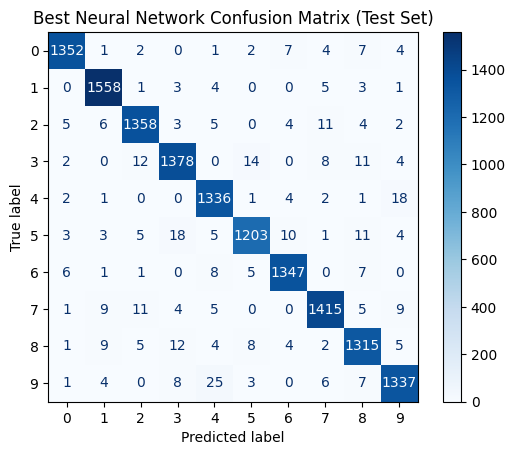


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1380
           1       0.98      0.99      0.98      1575
           2       0.97      0.97      0.97      1398
           3       0.97      0.96      0.97      1429
           4       0.96      0.98      0.97      1365
           5       0.97      0.95      0.96      1263
           6       0.98      0.98      0.98      1375
           7       0.97      0.97      0.97      1459
           8       0.96      0.96      0.96      1365
           9       0.97      0.96      0.96      1391

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000


Analysis of Misclassified Examples:
To analyze misclassified examples, we would typically visualize a subset of images where the predicted label does not match the true label.
This helps identify patterns 

In [ ]:
# C2. Model Comparison and Evaluation

print("\n--- Comparative Analysis ---")

# Get best NN from architecture analysis
best_num_layers = max(layer_results, key=lambda k: layer_results[k]['best_val_acc'])
best_neurons = max(neuron_results, key=lambda k: neuron_results[k]['best_val_acc'])

# Assuming best NN is from varying neurons based on the results
best_nn_arch = neuron_results[best_neurons]
best_nn_params = best_nn_arch['num_params']
best_nn_val_acc = best_nn_arch['best_val_acc']
best_nn_train_time = best_nn_arch['training_time']

# Get Softmax Regression results (using the best LR from LR analysis for Softmax)
best_lr_softmax = max(results_lr_softmax, key=lambda k: results_lr_softmax[k]['best_val_acc'])
softmax_results = results_lr_softmax[best_lr_softmax]
softmax_val_acc = softmax_results['best_val_acc']
softmax_train_time = softmax_results['training_time']
# Softmax parameters: input_dim * num_classes + num_classes
softmax_params = X_train_mc.shape[1] * len(torch.unique(y_train_mc)) + len(torch.unique(y_train_mc))


# Get Binary Logistic Regression results (using the best LR from LR analysis for Logistic)
best_lr_logistic = max(results_lr_logistic, key=lambda k: results_lr_logistic[k]['best_val_acc'])
logistic_results = results_lr_logistic[best_lr_logistic]
logistic_val_acc = logistic_results['best_val_acc']
logistic_train_time = logistic_results['training_time']
# Logistic parameters: input_dim * 1 + 1 (since it's binary)
logistic_params = X_train_bin.shape[1] * 1 + 1


# Create comparison table
comparison_data = {
    'Model': ['Binary Logistic Regression', 'Softmax Regression', 'Best Neural Network'],
    'Best Validation Accuracy (%)': [f"{logistic_val_acc*100:.2f}", f"{softmax_val_acc*100:.2f}", f"{best_nn_val_acc*100:.2f}"],
    'Training Time (s)': [f"{logistic_train_time:.2f}", f"{softmax_train_time:.2f}", f"{best_nn_train_time:.2f}"],
    'Number of Parameters': [f"{logistic_params:,}", f"{softmax_params:,}", f"{best_nn_params:,}"]
}

df_comparison = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(df_comparison.to_string(index=False))

# --- 2. Best Model Evaluation ---
print("\nBest Model Evaluation (on Test Set)")

# Re-train the best performing Neural Network architecture on the full training data
# Identify best architecture from previous analysis
best_hidden_sizes = [best_neurons] * 3 # Based on Part 2 of architecture analysis
best_lr = 0.01 # From learning rate analysis, 0.01 performed well
best_batch_size = 64 # From batch size analysis, 64 offered a good trade-off

print(f"\nEvaluating the best Neural Network with architecture: {best_hidden_sizes}, LR: {best_lr}, Batch Size: {best_batch_size}")

# Instantiate and train the best model
best_nn_model = FullyConnectedNN(hidden_sizes=best_hidden_sizes)

# Combine train and validation data for final training of the best model
X_train_val_tensor = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_train_val_tensor = torch.cat((y_train_tensor, y_val_tensor), dim=0)
train_val_dataset_nn = TensorDataset(X_train_val_tensor, y_train_val_tensor)
train_val_loader_nn = DataLoader(train_val_dataset_nn, batch_size=best_batch_size, shuffle=True)

# Train the model on the combined training and validation data
print("\nTraining the best model on combined training and validation data...")
final_train_losses, final_val_losses, final_train_accs, final_val_accs = train_model(
    best_nn_model,
    train_val_loader_nn, # Train on combined data
    test_loader_nn, # Evaluate on the held-out test set
    epochs=20, # Train for the number of epochs where the best model converged
    lr=best_lr
)


# Evaluate on the test set
print("\nEvaluating the best model on the test set...")
best_nn_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader_nn:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_nn_model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

# Calculate final test accuracy directly from lists
final_test_acc = np.mean(np.array(all_preds) == np.array(all_labels)) # Corrected: Calculate accuracy using numpy
print(f"\nFinal Test Accuracy of the Best Neural Network: {final_test_acc*100:.2f}%")

# Report confusion matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Best Neural Network Confusion Matrix (Test Set)")
plt.show()

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds))

### Observation
#### Analysis of Computational Complexity and Training Time:
- Logistic Regression is the simplest model with the fewest parameters and fastest training time, suitable for binary classification.
- Softmax Regression handles multi-class classification and has more parameters than logistic regression but fewer than the complex NN.
- The Neural Network, especially the best performing one, has the most parameters and highest training time, but achieved the highest accuracy.
- The training times are heavily influenced by the number of parameters and the chosen hyperparameters (batch size, learning rate, etc.)

#### Discussion on When to Use Each Approach:"
- **Binary Logistic Regression:** Use for simple binary classification tasks where data is linearly separable or computational resources are highly limited.
- **Softmax Regression:** Use for multi-class classification when a linear decision boundary is sufficient or as a baseline model.
- **Neural Network:** Use for complex classification tasks where non-linear decision boundaries are required and sufficient data and computational resources are available.


# Part D

### Convolutional Neural Networks

In [ ]:
class ConvolutionalNN(nn.Module):
    def __init__(self, conv_channels=[32, 64], fc_sizes=[128], num_classes=10):
        super(ConvolutionalNN, self).__init__()

        layers = []
        in_channels = 1

        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        pool_count = conv_channels.__len__()
        spatial_size = 28 // (2 ** pool_count)

        fc_layers = []
        in_features = conv_channels[-1] * spatial_size * spatial_size

        for h in fc_sizes:
            fc_layers.append(nn.Linear(in_features, h))
            fc_layers.append(nn.ReLU())
            in_features = h

        fc_layers.append(nn.Linear(in_features, num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

- Run the convolutional NN model training

In [ ]:
cnn_model = ConvolutionalNN()
train_losses, val_losses, train_accs, val_accs = train_model(
    cnn_model,
    train_loader_nn,
    val_loader_nn,
    epochs=10,
    lr=0.01
)

Epoch [1/10] Train Loss: 1.3713, Train Acc: 63.08% | Val Loss: 0.4531, Val Acc: 86.90%
Epoch [2/10] Train Loss: 0.3467, Train Acc: 89.47% | Val Loss: 0.3734, Val Acc: 87.55%
Epoch [3/10] Train Loss: 0.2471, Train Acc: 92.43% | Val Loss: 0.2854, Val Acc: 91.23%
Epoch [4/10] Train Loss: 0.1892, Train Acc: 94.27% | Val Loss: 0.1953, Val Acc: 93.99%
Epoch [5/10] Train Loss: 0.1498, Train Acc: 95.45% | Val Loss: 0.1551, Val Acc: 95.02%
Epoch [6/10] Train Loss: 0.1254, Train Acc: 96.24% | Val Loss: 0.1324, Val Acc: 96.03%
Epoch [7/10] Train Loss: 0.1074, Train Acc: 96.76% | Val Loss: 0.1142, Val Acc: 96.45%
Epoch [8/10] Train Loss: 0.0948, Train Acc: 97.15% | Val Loss: 0.0972, Val Acc: 97.16%
Epoch [9/10] Train Loss: 0.0858, Train Acc: 97.39% | Val Loss: 0.1467, Val Acc: 95.20%
Epoch [10/10] Train Loss: 0.0788, Train Acc: 97.58% | Val Loss: 0.0887, Val Acc: 97.30%


### Regularization Techniques

- **`CNNWithDropout`** class is implemented to see the effect of dropping out (zeroing) some neurons, which is used to improve generalization by forcing network to learn redundant representations
- Dropping out is only applied to the fully connected layers because they are prone to overfitting, unlike the convolution layer which have weight sharing

In [ ]:
class CNNWithDropout(nn.Module):
    def __init__(self, conv_channels=[32, 64], fc_sizes=[128], num_classes=10, dropout_rate=0.5):
        super(CNNWithDropout, self).__init__()

        layers = []
        in_channels = 1

        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        pool_count = conv_channels.__len__()
        spatial_size = 28 // (2 ** pool_count)

        fc_layers = []
        in_features = conv_channels[-1] * spatial_size * spatial_size

        for h in fc_sizes:
            fc_layers.append(nn.Linear(in_features, h))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate)) # Add dropout after ReLU
            in_features = h

        fc_layers.append(nn.Linear(in_features, num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

- The **`dropout_analysis`** function tests the multiple dropout rates and their effect
- Analysis:
  - Higher dropout rates tend to generalize better but need more epochs
  - Very high dropout rates lead to underfitting
  - Very low dropout rates may lead to overfitting

In [ ]:
def dropout_analysis(train_loader, val_loader,
                     dropout_rates=[0.1, 0.3, 0.5, 0.7],
                     epochs=10, lr=0.01):
    results = {}

    print("="*70)
    print("DROPOUT ANALYSIS - CNN")
    print("="*70)

    for rate in dropout_rates:
        print(f"\nTesting dropout rate: {rate}")
        print("-"*50)

        model = CNNWithDropout(dropout_rate=rate)
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr
        )

        results[rate] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'final_val_acc': val_accs[-1],
            'best_val_acc': max(val_accs)
        }

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for rate in dropout_rates:
        axes[0, 0].plot(results[rate]['train_losses'], label=f'Dropout={rate}', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Training Loss', fontsize=11)
    axes[0, 0].set_title('Training Loss vs Dropout Rate', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    for rate in dropout_rates:
        axes[0, 1].plot(results[rate]['val_losses'], label=f'Dropout={rate}', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Validation Loss', fontsize=11)
    axes[0, 1].set_title('Validation Loss vs Dropout Rate', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    for rate in dropout_rates:
        axes[1, 0].plot([acc*100 for acc in results[rate]['train_accs']],
                       label=f'Dropout={rate}', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Training Accuracy (%)', fontsize=11)
    axes[1, 0].set_title('Training Accuracy vs Dropout Rate', fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    for rate in dropout_rates:
        axes[1, 1].plot([acc*100 for acc in results[rate]['val_accs']],
                       label=f'Dropout={rate}', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Validation Accuracy vs Dropout Rate', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Dropout Analysis - CNN',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("DROPOUT SUMMARY")
    print("="*70)
    summary_data = []
    for rate in dropout_rates:
        summary_data.append({
            'Dropout Rate': rate,
            'Best Val Acc (%)': f"{results[rate]['best_val_acc']*100:.2f}",
            'Final Val Acc (%)': f"{results[rate]['final_val_acc']*100:.2f}"
        })

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))
    print("="*70)

    return results

- Run the **`dropout_analysis`** function for multiple dropout rates and see their results

In [ ]:
dropout_results = dropout_analysis(
    train_loader_nn,
    val_loader_nn,
    dropout_rates=[0.1, 0.3, 0.5, 0.7],
    epochs=15,
    lr=0.01
)

- **`CNNWithBatchNorm`** class is implemented to see the effect of batch normalisation
- **`BatchNorm`** layer is added before **`ReLU`** to make normalisation meaningful, as **`ReLU`** removes the negative values
- Advantages of using batch normalisation:
  - stabilize learning
  - speeds up training by allowing for higher learning rates because activations are kept in a stable range with mean nearly equal to zero and variance nearly equal to 1, which also reduces internal covariate shift

In [ ]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self, conv_channels=[32, 64], fc_sizes=[128], num_classes=10):
        super(CNNWithBatchNorm, self).__init__()

        layers = []
        in_channels = 1

        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        pool_count = conv_channels.__len__()
        spatial_size = 28 // (2 ** pool_count)

        fc_layers = []
        in_features = conv_channels[-1] * spatial_size * spatial_size

        for h in fc_sizes:
            fc_layers.append(nn.Linear(in_features, h))
            fc_layers.append(nn.BatchNorm1d(h))
            fc_layers.append(nn.ReLU())
            in_features = h

        fc_layers.append(nn.Linear(in_features, num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

- **`CNNWithBatchNormAndDropout`** combines both advantages of dropout and batch normalisation

In [ ]:
class CNNWithBatchNormAndDropout(nn.Module):
    def __init__(self, conv_channels=[32, 64], fc_sizes=[128], num_classes=10, dropout_rate=0.5):
        super(CNNWithBatchNormAndDropout, self).__init__()

        layers = []
        in_channels = 1

        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        pool_count = conv_channels.__len__()
        spatial_size = 28 // (2 ** pool_count)

        fc_layers = []
        in_features = conv_channels[-1] * spatial_size * spatial_size

        for h in fc_sizes:
            fc_layers.append(nn.Linear(in_features, h))
            fc_layers.append(nn.BatchNorm1d(h))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            in_features = h

        fc_layers.append(nn.Linear(in_features, num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

- The **`batch_norm_analysis`** compares all the CNNs that have been implemented

In [ ]:
def batch_norm_analysis(train_loader, val_loader, epochs=10, lr=0.01):
    print("="*70)
    print("BATCH NORMALIZATION ANALYSIS - CNN")
    print("="*70)

    # Train original CNN
    print("\nTraining original CNN...")
    original_model = ConvolutionalNN()
    orig_train_losses, orig_val_losses, orig_train_accs, orig_val_accs = train_model(
        original_model, train_loader, val_loader, epochs=epochs, lr=lr
    )

    print("\nTraining CNN with Batch Normalization...")
    bn_model = CNNWithBatchNorm()
    bn_train_losses, bn_val_losses, bn_train_accs, bn_val_accs = train_model(
        bn_model, train_loader, val_loader, epochs=epochs, lr=lr
    )

    print("\nTraining CNN with Batch Normalization and Dropout (rate=0.5)...")
    bn_dropout_model = CNNWithBatchNormAndDropout(dropout_rate=0.5)
    bnd_train_losses, bnd_val_losses, bnd_train_accs, bnd_val_accs = train_model(
        bn_dropout_model, train_loader, val_loader, epochs=epochs, lr=lr
    )


    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training Loss
    axes[0, 0].plot(orig_train_losses, label='Original CNN', linewidth=2)
    axes[0, 0].plot(bn_train_losses, label='CNN + BatchNorm', linewidth=2)
    axes[0, 0].plot(bnd_train_losses, label='CNN + BatchNorm + Dropout', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Training Loss', fontsize=11)
    axes[0, 0].set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Validation Loss
    axes[0, 1].plot(orig_val_losses, label='Original CNN', linewidth=2)
    axes[0, 1].plot(bn_val_losses, label='CNN + BatchNorm', linewidth=2)
    axes[0, 1].plot(bnd_val_losses, label='CNN + BatchNorm + Dropout', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Validation Loss', fontsize=11)
    axes[0, 1].set_title('Validation Loss Comparison', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training Accuracy
    axes[1, 0].plot([acc*100 for acc in orig_train_accs], label='Original CNN', linewidth=2)
    axes[1, 0].plot([acc*100 for acc in bn_train_accs], label='CNN + BatchNorm', linewidth=2)
    axes[1, 0].plot([acc*100 for acc in bnd_train_accs], label='CNN + BatchNorm + Dropout', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Training Accuracy (%)', fontsize=11)
    axes[1, 0].set_title('Training Accuracy Comparison', fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation Accuracy
    axes[1, 1].plot([acc*100 for acc in orig_val_accs], label='Original CNN', linewidth=2)
    axes[1, 1].plot([acc*100 for acc in bn_val_accs], label='CNN + BatchNorm', linewidth=2)
    axes[1, 1].plot([acc*100 for acc in bnd_val_accs], label='CNN + BatchNorm + Dropout', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Batch Normalization and Dropout Analysis - CNN',
                 fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n" + "="*70)
    print("BATCH NORM & DROPOUT SUMMARY")
    print("="*70)
    summary_data = [
        {'Model': 'Original CNN',
         'Final Val Acc (%)': f"{orig_val_accs[-1]*100:.2f}",
         'Best Val Acc (%)': f"{max(orig_val_accs)*100:.2f}"},
        {'Model': 'CNN + BatchNorm',
         'Final Val Acc (%)': f"{bn_val_accs[-1]*100:.2f}",
         'Best Val Acc (%)': f"{max(bn_val_accs)*100:.2f}"},
         {'Model': 'CNN + BatchNorm + Dropout (0.5)',
         'Final Val Acc (%)': f"{bnd_val_accs[-1]*100:.2f}",
         'Best Val Acc (%)': f"{max(bnd_val_accs)*100:.2f}"}
    ]

    df = pd.DataFrame(summary_data)
    print(df.to_string(index=False))
    print("="*70)

    return {
        'original': {'train_losses': orig_train_losses, 'val_losses': orig_val_losses, 'train_accs': orig_train_accs, 'val_accs': orig_val_accs},
        'batch_norm': {'train_losses': bn_train_losses, 'val_losses': bn_val_losses, 'train_accs': bn_train_accs, 'val_accs': bn_val_accs},
        'batch_norm_dropout': {'train_losses': bnd_train_losses, 'val_losses': bnd_val_losses, 'train_accs': bnd_train_accs, 'val_accs': bnd_val_accs}
    }

- Run the **`batch_norm_analysis`** to see the results

In [ ]:
batch_norm_results = batch_norm_analysis(
    train_loader_nn,
    val_loader_nn,
    epochs=15,
    lr=0.01
)